In [35]:
import pandas as pd
from tbparse import SummaryReader
import os

log_dir = os.path.expanduser("~/lis-cluster/emergent_communication/emergent_communication/lightning_logs")
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars

hp = reader.hparams
hp

,tag,value,dir_name
0,accelerator,None,version_1053506
1,accumulate_grad_batches,None,version_1053506
2,amp_backend,native,version_1053506
3,amp_level,None,version_1053506
4,auto_lr_find,0.0,version_1053506
...,...,...,...
9307,track_grad_norm,-1.0,version_1053737
9308,val_check_interval,1.0,version_1053737
9309,vocab_size,100.0,version_1053737
9310,weights_save_path,None,version_1053737


In [36]:
NUM_SENDERS = 1
NUM_RECEIVERS = 1

In [37]:
import numpy as np

def get_metric_value(df, metric_name, dir_name, step):
    values = df[(df['dir_name'] == dir_name) & (df["step"] == step) & (df["tag"] == metric_name)].value.values
    if len(values) == 0:
        raise ValueError()
    assert len(values) == 1
    return values[0]

def get_metric_values(df, metric_name, dir_names):
    values = df[(df['dir_name'].isin(dir_names)) & (df["tag"] == metric_name)].value.values
    return values

def get_hparam(hp, hparam_name, dir_name):
    values = hp[(hp['dir_name'] == dir_name) & (hp['tag'] == hparam_name)].value.values
    if len(values) == 2: # TODO why??
        assert values[0] == values[1]
    return values[0]

def get_unique_hparams(hp, hparam_name, dir_names):
    values = hp[hp['dir_name'].isin(dir_names) & (hp['tag'] == hparam_name)].value.unique()
    return values

def get_metrics(runs):
    train_accs = []
    val_accs = []
    test_accs = []
    topsims = []
    entropies = []
    posdisses = []
    bosdisses = []

    for run in runs:
        df_filtered = df[df['dir_name'] == run]
        max_val_acc = df_filtered[df_filtered["tag"]=="best_val_acc_no_noise"].value.max()
        best_runs = df_filtered[(df_filtered["tag"]=="best_val_acc_no_noise") & (df_filtered["value"] == max_val_acc)]

        dir_names = best_runs.dir_name.unique()
        assert len(dir_names) == 1
        dir_name = dir_names[0]

        step = best_runs.step.min()

        try:
            train_acc = get_metric_value(df_filtered, "train_acc_no_noise", dir_name, step)
            test_acc = get_metric_value(df_filtered, "test_acc_no_noise", dir_name, step)
            val_acc = get_metric_value(df_filtered, "val_acc_no_noise", dir_name, step)
            topsim = get_metric_value(df_filtered, "topsim", dir_name, step)
            posdis = get_metric_value(df_filtered, "posdis", dir_name, step)
            bosdis = get_metric_value(df_filtered, "bosdis", dir_name, step)
        except ValueError:
            print(f"No complete set of metrics found for run: {dir_name} step {step}")
            continue
        entropy_coeff = get_hparam(hp, "sender_entropy_coeff", dir_name)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        topsims.append(topsim)
        entropies.append(entropy_coeff)
        posdisses.append(posdis)
        bosdisses.append(bosdis)
    return train_accs, val_accs, test_accs, topsims, posdisses, bosdisses, entropies

In [41]:
data = []
for attr, val in [(2, 16), (4, 4), (4, 5), (2, 50), (2, 100)]:
    print(f"\n\n\nAttr: {attr} Values: {val}")

    runs_val = set(hp[(hp['tag']=='num_values') & (hp['value'] == val)].dir_name)
    runs_attr = set(hp[(hp['tag']=='num_attributes') & (hp['value'] == attr)].dir_name)

    runs_num_agents = set(hp[(hp['tag']=='num_senders') & (hp['value'] == NUM_SENDERS)].dir_name) & set(hp[(hp['tag']=='num_receivers') & (hp['value'] == NUM_RECEIVERS)].dir_name)

    for feedback in [0, 1]:
        runs_config = runs_val & runs_attr & runs_num_agents
        if len(hp[hp.dir_name.isin(runs_config) & (hp['tag']=='feedback')]) > 0:
            runs_cr = set(hp[(hp['tag']=='feedback') & (hp['value'] == feedback)].dir_name)
        else:
            runs_cr = set(hp[(hp['tag']=='clarification_requests') & (hp['value'] == feedback)].dir_name)

        runs_config = runs_cr & runs_config
        if feedback:
            print("\nFeedback")
        else:
            print("\nBaseline")
        print(f"Found {len(runs_config)} runs for config") #: {runs_config}

        entropy_coeff_values = get_unique_hparams(hp, "sender_entropy_coeff", runs_config)
        # print(entropy_coeff_values)
        val_acc_means = {}

        for entropy_coeff in entropy_coeff_values:
            entropy_filter = set(hp[(hp['tag']=='sender_entropy_coeff') & (hp['value'] == entropy_coeff)].dir_name)
            runs_entropy = runs_config & entropy_filter

            _, val_accs, _, _, _, _, _ = get_metrics(runs_entropy)

            if len(val_accs) == 0:
                continue

            # print(val_accs)
            val_acc_means[entropy_coeff] = np.mean(val_accs)

        if len(val_acc_means) == 0:
            continue

        print(val_acc_means)
        best_entropy_coeff = max(val_acc_means, key=val_acc_means.get)
        print(f"Best entropy coeff: {best_entropy_coeff}")

        entropy_filter = set(hp[(hp['tag']=='sender_entropy_coeff') & (hp['value'] == best_entropy_coeff)].dir_name)
        runs_best_entropy = runs_config & entropy_filter
        print(runs_best_entropy)

        train_accs, val_accs, test_accs, topsims, posdisses, bosdisses, entropies = get_metrics(runs_best_entropy)
            #
            # print(f"Best version: {dir_name} step {step}, entropy coeff {entropy_coeff}, test acc: {test_acc:.2f}")
            #
        for i in range(len(val_accs)):
            data.append({
                "feedback": feedback,
                "train_acc": train_accs[i],
                "test_acc": test_accs[i],
                "val_acc": val_accs[i],
                "topsim": topsims[i],
                "posdis": posdisses[i],
                "bosdis": bosdisses[i],
                "entropy_coeff": entropies[i],
                "attributes": attr,
                "values": val,
            })

data = pd.DataFrame(data)





Attr: 2 Values: 16

Baseline
Found 0 runs for config

Feedback
Found 0 runs for config



Attr: 4 Values: 4

Baseline
Found 25 runs for config
{0.05: 0.973913037776947, 0.1: 0.991304349899292, 0.3: 0.913043475151062, 0.5: 0.92173912525177, 0.7: 0.791304349899292}
Best entropy coeff: 0.1
{'version_1053677', 'version_1053681', 'version_1053683', 'version_1053679', 'version_1053685'}

Feedback
Found 25 runs for config
{0.05: 0.965217387676239, 0.1: 0.973913049697876, 0.3: 0.982608699798584, 0.5: 0.930434787273407, 0.7: 0.982608699798584}
Best entropy coeff: 0.3
{'version_1053694', 'version_1053696', 'version_1053692', 'version_1053688', 'version_1053690'}



Attr: 4 Values: 5

Baseline
Found 0 runs for config

Feedback
Found 0 runs for config



Attr: 2 Values: 50
egr

Baseline
Found 15 runs for config
{0.05: 0.6266666650772095, 0.1: 0.6296296318372091, 0.3: 0.8088888923327128, 0.5: 0.965925931930542, 0.7: 0.9792592724164327}
Best entropy coeff: 0.7
{'version_1053534', 'version_1053530

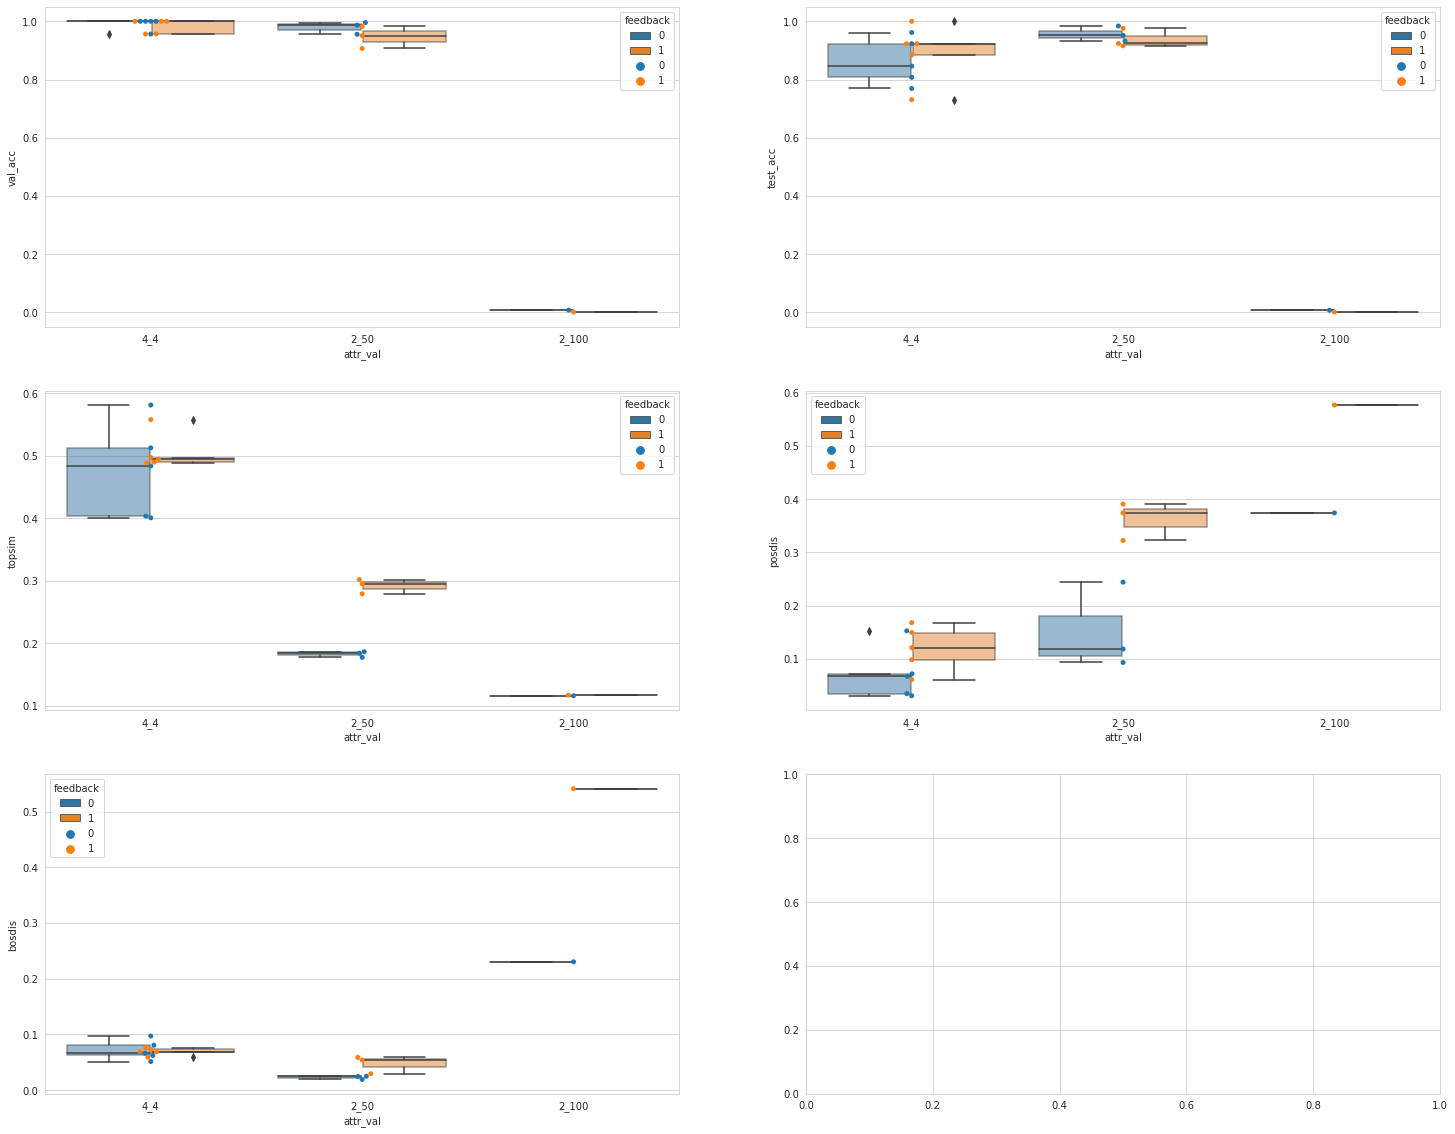

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

data["attr_val"] = data["attributes"].map(str) + "_" + data["values"].map(str)

fig, axes = plt.subplots(3, 2, figsize=(25, 20))
# plt.figure(figsize=(20, 10))
# sns.swarmplot(data=data, x="feedback", y="test_acc_no_noise", hue="entropy_coeff")
sns.boxplot(ax=axes[0, 0], data=data, x="attr_val", y="val_acc", hue="feedback", boxprops=dict(alpha=.5))
sns.swarmplot(ax=axes[0, 0], data=data, x="attr_val", y="val_acc", hue="feedback")

sns.boxplot(ax=axes[0, 1], data=data, x="attr_val", y="test_acc", hue="feedback", boxprops=dict(alpha=.5))
sns.swarmplot(ax=axes[0, 1], data=data, x="attr_val", y="test_acc", hue="feedback")

sns.boxplot(ax=axes[1, 0], data=data, x="attr_val", y="topsim", hue="feedback", boxprops=dict(alpha=.5))
sns.swarmplot(ax=axes[1, 0], data=data, x="attr_val", y="topsim", hue="feedback")


sns.boxplot(ax=axes[1, 1], data=data, x="attr_val", y="posdis", hue="feedback", boxprops=dict(alpha=.5))
sns.swarmplot(ax=axes[1, 1], data=data, x="attr_val", y="posdis", hue="feedback")

sns.boxplot(ax=axes[2, 0], data=data, x="attr_val", y="bosdis", hue="feedback", boxprops=dict(alpha=.5))
sns.swarmplot(ax=axes[2, 0], data=data, x="attr_val", y="bosdis", hue="feedback")


name = log_dir.split("/")[-2]
plt.savefig("plots/"+name+".pdf", dpi=300)

